# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoModelForSequenceClassification, AutoConfig

# import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics
)

### Setup

In [3]:
MODEL_NAME = "distilbert-base-uncased" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
DATA_PATH = "../data/data_small.csv"
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
OUTPUT_DIR = "../models/distilbert_finetuned_1/trainer_output"
SAVE_PATH = "../models/distilbert_finetuned_1/pytorch_model"

### Get data

In [5]:
train_dataset, test_dataset, y_train, le = get_encode_tokenize_data(DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:encode the label column
INFO:root:tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:create TextDatasets (train & test)


### Model Initialization

In [6]:
num_classes = len(np.unique(y_train))
num_classes

6

In [7]:
# model = AutoModelForSequenceClassification.from_pretrained(
#     MODEL_TRAINING_PATH,
#     num_labels=num_classes,
#     problem_type="single_label_classification"
# )

# # model.gradient_checkpointing_enable() 

In [8]:
# Load config and set dropout
config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes # Set number of labels for classification
#config.seq_classif_dropout = 0.5  # DistilBERT's classifier-specific dropout parameter
#config.attention_dropout = 0.3 # Set attention dropout, default is 0.1
config.dropout = 0.3 # Set dropout, default is 0.1

# Load model with updated config
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_TRAINING_PATH,
    config=config  # Pass modified config
)

# model.gradient_checkpointing_enable() 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# # Fine-tuning 1 

# # Freeze the first layers. 
# for param in model.distilbert.transformer.layer[:1].parameters():
#     param.requires_grad = False

In [10]:
params = {
      "learning_rate": 2e-5,
      "weight_decay": 0.01,
      "num_train_epochs": 4,
      "evaluation_strategy": "epoch",
      "class_weight":False,
      "train_batch_size": 4,
      "eval_batch_size": 8,
      "dropout": 0.3,
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert_small_7")
mlflow.log_params(params)

Active run_id: ee11832efbb645e6a196eeec2a9f14c7


In [11]:
trainer = createTrainer(
    model= model, 
    train_dataset = train_dataset,
    test_dataset = test_dataset,
    output_dir= OUTPUT_DIR, 
    y_train=y_train, 
    class_weight=False, 
    epochs=4, 
    learning_rate=3e-5, 
    weight_decay = 0.01, 
    train_batch_size=4, 
    eval_batch_size=8 )

INFO:root:defining training arguments
INFO:root:get normal trainer


### Execute Training

In [12]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [13]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [14]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,1.325100,1.167351,0.585000
2,0.948000,1.033013,0.598333
3,0.824200,1.059345,0.636667
4,0.523300,1.094253,0.645000


TrainOutput(global_step=1400, training_loss=0.9383124283381871, metrics={'train_runtime': 501.616, 'train_samples_per_second': 11.164, 'train_steps_per_second': 2.791, 'total_flos': 741870349516800.0, 'train_loss': 0.9383124283381871, 'epoch': 4.0})

### Evaluation


In [15]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.66      0.56      0.61       101
  appeal_to_authority       0.63      0.76      0.69        87
    appeal_to_emotion       0.70      0.48      0.56       101
        false_dilemma       0.85      0.77      0.81       100
faulty_generalization       0.39      0.51      0.44       102
                 none       0.51      0.54      0.53       109

             accuracy                           0.60       600
            macro avg       0.62      0.60      0.61       600
         weighted avg       0.62      0.60      0.60       600

[[57 13  6  2 17  6]
 [ 3 66  5  2  3  8]
 [12  7 48  1 27  6]
 [ 2  2  1 77  3 15]
 [ 6  9  7  7 52 21]
 [ 6  8  2  2 32 59]]


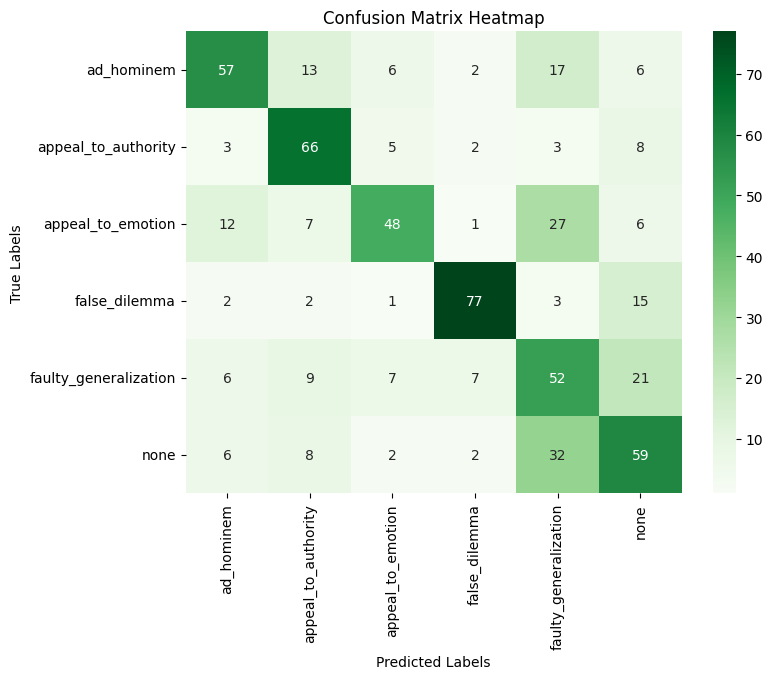

INFO:basic_functions:brier score


Multiclass Brier score: 0.5100047294156146


In [16]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                       precision    recall  f1-score   support

           ad_hominem       0.89      0.86      0.87       234
  appeal_to_authority       0.78      0.85      0.81       204
    appeal_to_emotion       0.86      0.68      0.76       235
        false_dilemma       0.94      0.79      0.86       233
faulty_generalization       0.68      0.84      0.75       238
                 none       0.71      0.75      0.73       256

             accuracy                           0.79      1400
            macro avg       0.81      0.80      0.80      1400
         weighted avg       0.81      0.79      0.80      1400

[[201   7   7   0  11   8]
 [  2 174   5   1  11  11]
 [  9  24 160   2  31   9]
 [  2   2   1 183  10  35]
 [  6   6   6   2 201  17]
 [  7  11   6   7  32 193]]


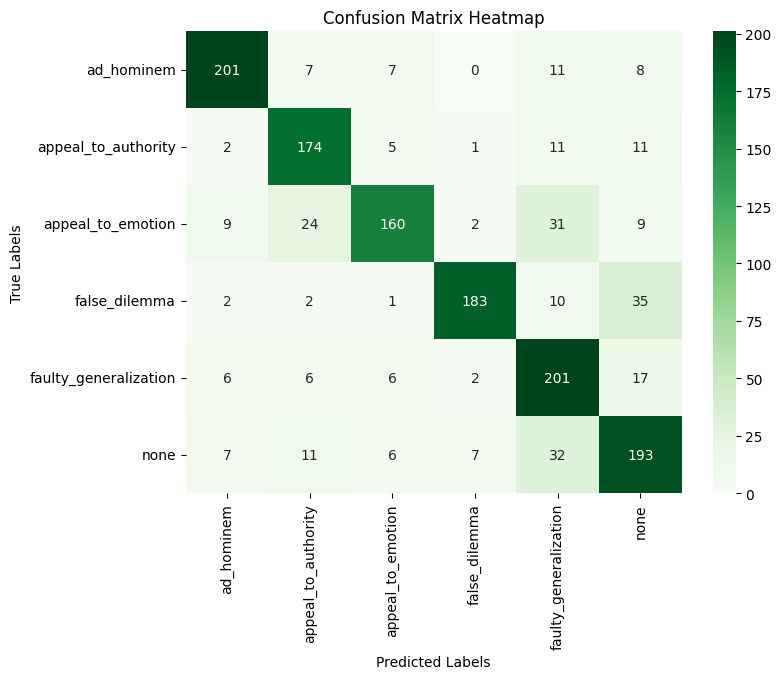

INFO:basic_functions:brier score


Multiclass Brier score: 0.31170343095457903


In [17]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [18]:
mlflow.end_run()

🏃 View run Distilbert_small_7 at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/ee11832efbb645e6a196eeec2a9f14c7
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [19]:
#save with pytorch
#mlflow.pytorch.save_model(model, path=SAVE_PATH)